In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import sys
import pickle

In [2]:
import h5py

def print_hdf5_schema(file_path):
    def print_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}")
            # print(f"Shape: {obj.shape}")
            # print(f"Dtype: {obj.dtype}")
            # print("\n")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
            # print("\n")

    def print_nested_datasets(group, prefix="", ignore_numbers=True):
        printed_datasets = set()
        for key in group.keys():
            item = group[key]
            path = f"{prefix}/{key}"
            if isinstance(item, h5py.Dataset):
                if ignore_numbers and key.isdigit():
                    continue
                if path in printed_datasets:
                    continue
                printed_datasets.add(path)
                print_dataset(path, item)
            elif isinstance(item, h5py.Group):
                print_nested_datasets(item, path, ignore_numbers)

    with h5py.File(file_path, "r") as file:
        print_nested_datasets(file)


In [3]:
def group_data_by_amplitude(data, amplitude, bin_size):
    max_amplitude = np.nanmax(amplitude)
    min_amplitude = np.nanmin(amplitude)
    bins = np.arange(min_amplitude, max_amplitude + bin_size, bin_size)
    digitized = np.digitize(amplitude, bins)
    groups = []
    mean_data = []
    std_data = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = digitized == i
        if np.sum(mask) > 0:
            groups.append(data[mask])
            mean_data.append(np.nanmean(data[mask]))
            std_data.append(np.nanstd(data[mask]))
            bin_centers.append((bins[i - 1] + bins[i]) / 2)

    return groups, np.array(mean_data), np.array(std_data), np.array(bin_centers)

In [4]:
STAB_FILE = "../data/stability_b1_worst_zeta_max.h5"
LOGDISP_FILE = "../data/log_displacement_b1_worst_zeta_max.h5"
REM_FILE = "../data/rem_b1_worst_zeta_max.h5"
GALI_FILE = "../data/gali_b1_worst_zeta_max.h5"
LYAP_FIT_FILE = "../data/lyapunov_fit_b1_worst_zeta_max.pkl"
REM_FIT_FILE = "../data/rem_fit_b1_worst_zeta_max.pkl"

In [5]:
with open(REM_FIT_FILE, "rb") as f:
    out_power, out_exp, b_power, b_exp, chroma = pickle.load(f)

In [6]:
with open(LYAP_FIT_FILE, "rb") as f:
    out_power_lyap, out_power_knee_lyap, b_power_lyap, b_power_knee_lyap, chroma_lyap = pickle.load(f)

In [7]:
with h5py.File(STAB_FILE, "r") as f:
    stability = f["stability"][:]

In [8]:
with h5py.File(LOGDISP_FILE, "r") as f:
    x0 = f["reference/initial/x_norm"][:]
    px0 = f["reference/initial/px_norm"][:]
    y0 = f["reference/initial/y_norm"][:]
    py0 = f["reference/initial/py_norm"][:]
    zeta0 = f["reference/initial/zeta_norm"][:]
    pzeta0 = f["reference/initial/pzeta_norm"][:]

    amplitude0 = np.sqrt(x0 ** 2 + px0 ** 2 + y0 ** 2 + py0 ** 2 + zeta0 ** 2 + pzeta0 ** 2)
    print(f["disp/x_norm/"].keys())
    times = np.array(sorted([int(s) for s in f["disp/x_norm/log_disp"].keys() if s.isdigit()]))

<KeysViewHDF5 ['initial', 'log_disp', 'log_disp_nobirk', 'normed_direction', 'px_norm', 'py_norm', 'pzeta_norm', 'x_norm', 'y_norm', 'zeta_norm']>


In [9]:
with h5py.File(LOGDISP_FILE, "r") as f:
    disp_x = np.array([f["disp/x_norm/log_disp/{}".format(i)] for i in times])

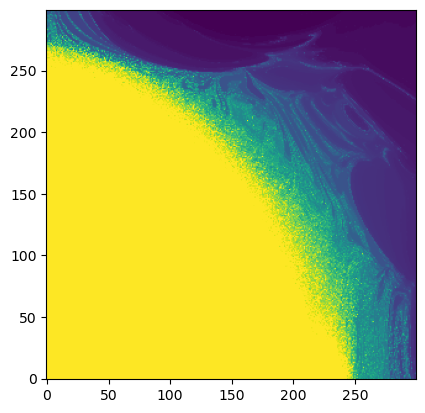

In [10]:
plt.imshow(np.log10(stability).reshape(300, 300), origin="lower")

/tmp/ipykernel_37680/2951272799.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(disp_x[-1]).reshape(300, 300), origin="lower")


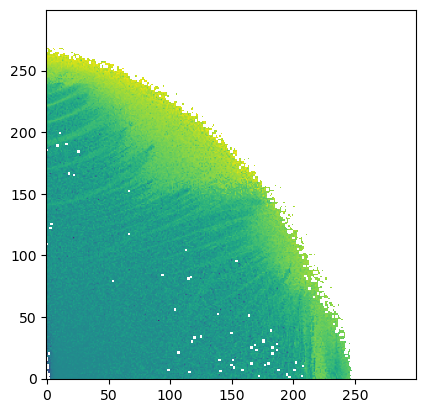

In [56]:
plt.imshow(np.log10(disp_x[-1]).reshape(300, 300), origin="lower")

In [14]:
last_good_lyap = np.ones(90000) * np.nan

# fill in the last good lyapunov exponent evaluated at the last good time
for i in range(90000):
    try:
        last_good_lyap[i] = disp_x[np.where(~np.isnan(disp_x[:,i]))[0][-1], i]
    except IndexError:
        last_good_lyap[i] = np.nan

# last_good_lyap[last_good_lyap <= 0] = np.nanmin(last_good_lyap[last_good_lyap > 0])

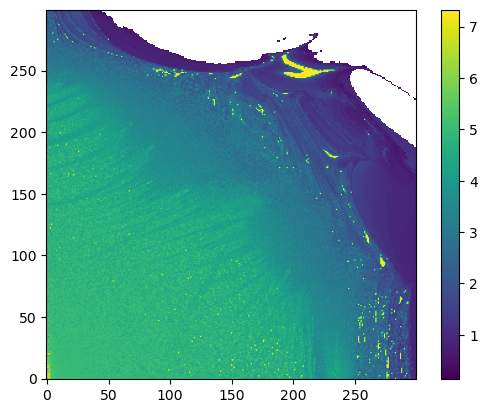

In [12]:
plt.imshow(np.log10(1/last_good_lyap).reshape(300, 300), origin="lower")
plt.colorbar()

/tmp/ipykernel_22503/3879094855.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(bin_centers, 10**mean_stability, "o", label="Survival time", markersize=4, marker="o")
/tmp/ipykernel_22503/3879094855.py:4: RuntimeWarning: invalid value encountered in log10
  _, mean_rem, std_rem, bin_centers = group_data_by_amplitude(np.log10(1/b_exp).copy(), amplitude0, 0.1)
/tmp/ipykernel_22503/64641738.py:14: RuntimeWarning: Mean of empty slice
  mean_data.append(np.nanmean(data[mask]))
/home/HPC/camontan/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_22503/3879094855.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precede

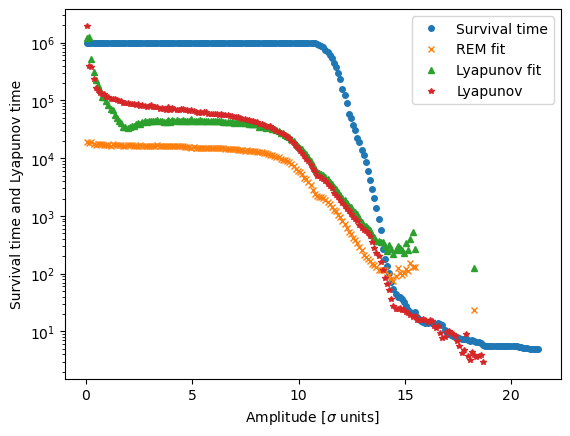

In [35]:
_, mean_stability, std_stability, bin_centers = group_data_by_amplitude(np.log10(stability), amplitude0, 0.1)
plt.plot(bin_centers, 10**mean_stability, "o", label="Survival time", markersize=4, marker="o")

_, mean_rem, std_rem, bin_centers = group_data_by_amplitude(np.log10(1/b_exp).copy(), amplitude0, 0.1)
plt.plot(bin_centers, 10**mean_rem, "o", label="REM fit", markersize=4, marker="x")

_, mean_lyap_fit, std_lyap_fit, bin_centers = group_data_by_amplitude(np.log10(1/10**b_power_knee_lyap), amplitude0, 0.1)
plt.plot(bin_centers, 10**mean_lyap_fit, "o", label="Lyapunov fit", markersize=4, marker="^")

_, mean_lyap, std_lyap, bin_centers = group_data_by_amplitude(np.log10(1/last_good_lyap), amplitude0, 0.1)
plt.plot(bin_centers, 10**mean_lyap, "o", label="Lyapunov", markersize=4, marker="*")

plt.xlabel("Amplitude $[\\sigma$ units$]$")
plt.ylabel("Survival time and Lyapunov time")
plt.yscale("log")
plt.legend()

In [87]:
print(len(mean_stability))
print(len(mean_rem))
print(len(mean_lyap))

213
213
213


In [23]:
import lmfit
def resid_morbidelli(params, x, data=None):
    alpha = params["alpha"].value
    beta = params["beta"].value

    # simple "linear" model fit
    model = beta * x + alpha
    if data is None:
        return model
    return model - data

[[Variables]]
    alpha:  0 (fixed)
    beta:   0.60394770 +/- 0.02098779 (3.48%) (init = 1)


Text(0, 0.5, 'Mean REM fit')

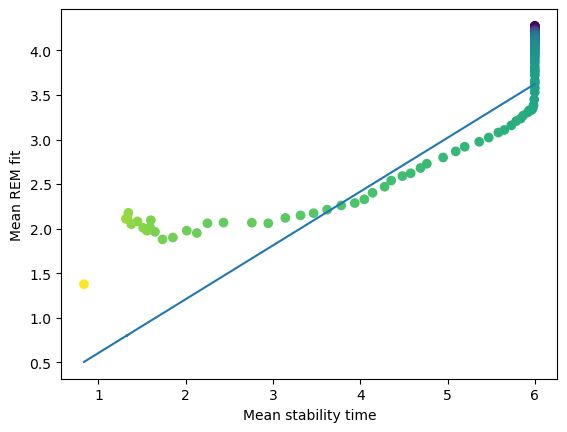

In [24]:
plt.scatter(mean_stability, mean_rem, c=bin_centers)

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0, vary=False)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_rem) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_rem[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(mean_stability[mask], final)

plt.xlabel("Mean stability time")
plt.ylabel("Mean REM fit")

[[Variables]]
    alpha:  0 (fixed)
    beta:   0.70013264 +/- 0.02758036 (3.94%) (init = 1)


Text(0, 0.5, 'Mean Lyapunov fit')

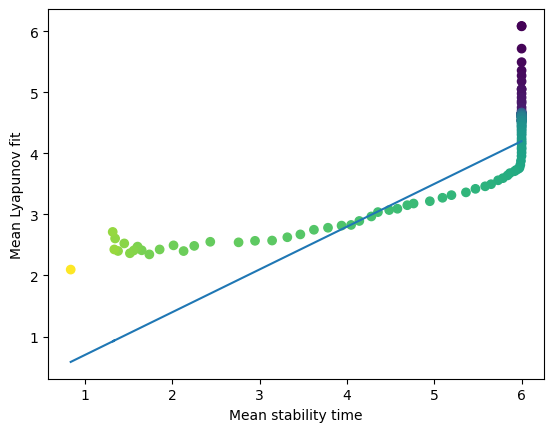

In [25]:
plt.scatter(mean_stability, mean_lyap_fit, c=bin_centers)

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0, vary=False)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_lyap_fit) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_lyap_fit[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(mean_stability[mask], final)

plt.xlabel("Mean stability time")
plt.ylabel("Mean Lyapunov fit")

[[Variables]]
    alpha:  0 (fixed)
    beta:   0.66079413 +/- 0.00961840 (1.46%) (init = 1)


Text(0, 0.5, 'Mean Lyapunov')

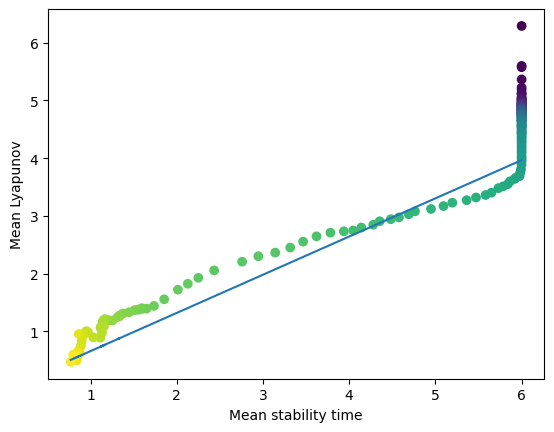

In [26]:
plt.scatter(mean_stability, mean_lyap, c=bin_centers)

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0, vary=False)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_lyap) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_lyap[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(mean_stability[mask], final)

plt.xlabel("Mean stability time")
plt.ylabel("Mean Lyapunov")

[[Variables]]
    alpha:  1.40870220 +/- 0.06362573 (4.52%) (init = 0)
    beta:   0.29582962 +/- 0.01531392 (5.18%) (init = 1)
[[Correlations]] (unreported correlations are < 0.500)
    C(alpha, beta) = -0.9088


Text(0, 0.5, 'Mean REM fit')

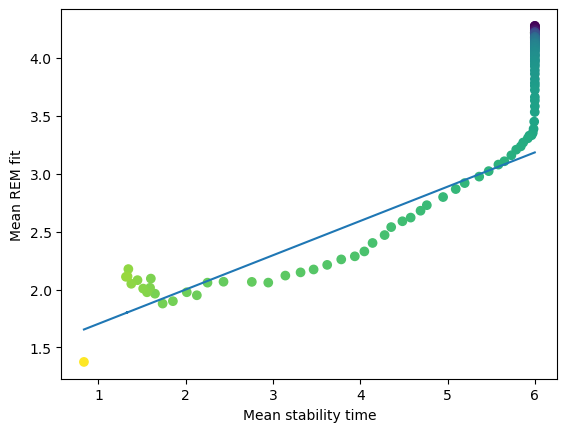

In [27]:
plt.scatter(mean_stability, mean_rem, c=bin_centers)

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_rem) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_rem[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(mean_stability[mask], final)

plt.xlabel("Mean stability time")
plt.ylabel("Mean REM fit")

[[Variables]]
    alpha:  1.90486751 +/- 0.05363505 (2.82%) (init = 0)
    beta:   0.28349091 +/- 0.01290928 (4.55%) (init = 1)
[[Correlations]] (unreported correlations are < 0.500)
    C(alpha, beta) = -0.9088


Text(0, 0.5, 'Mean Lyapunov fit')

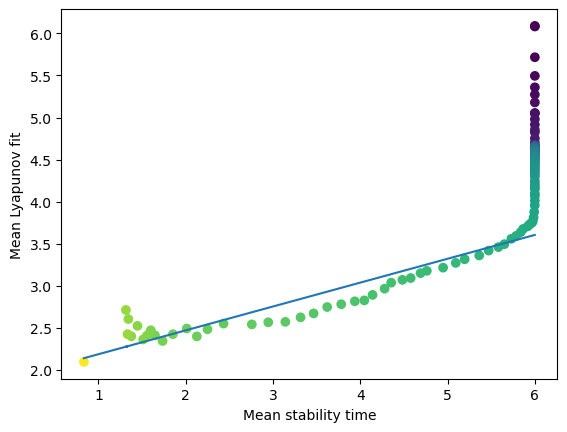

In [28]:
plt.scatter(mean_stability, mean_lyap_fit, c=bin_centers)

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_lyap_fit) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_lyap_fit[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(mean_stability[mask], final)

plt.xlabel("Mean stability time")
plt.ylabel("Mean Lyapunov fit")

[[Variables]]
    alpha:  0.42021374 +/- 0.03043692 (7.24%) (init = 0)
    beta:   0.55782552 +/- 0.00912781 (1.64%) (init = 1)
[[Correlations]] (unreported correlations are < 0.500)
    C(alpha, beta) = -0.8171


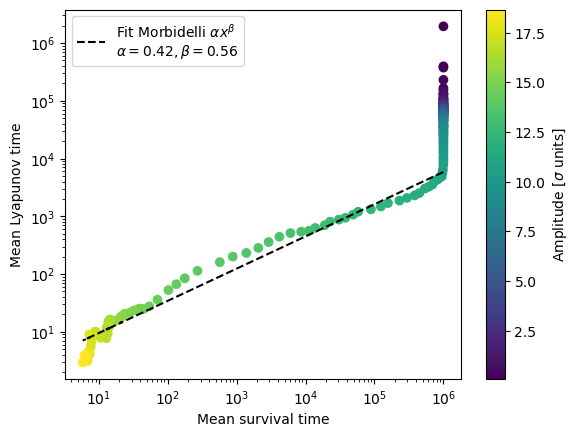

In [34]:
sc = plt.scatter(10**mean_stability, 10**mean_lyap, c=bin_centers)
plt.colorbar(sc, label="Amplitude $[\\sigma$ units$]$")

# create a set of Parameters
params = lmfit.Parameters()
params.add("alpha", value=0)
params.add("beta", value=1)

# do fit, here with leastsq model, but first clean up data from missing values.
mask = np.logical_and(np.isfinite(mean_lyap) & np.isfinite(mean_stability), mean_stability != 6.0)
x = mean_stability[mask]
y = mean_lyap[mask]
result = lmfit.minimize(resid_morbidelli, params, args=(x, y))

# calculate final result
final = resid_morbidelli(result.params, x)

# write error report
lmfit.report_fit(result.params, min_correl=0.5)

plt.plot(10**mean_stability[mask], 10**final, c="k", label=f"Fit Morbidelli $\\alpha x^\\beta$\n$\\alpha={result.params['alpha'].value:.2f},\\beta={result.params['beta'].value:.2f}$", linestyle="--")

plt.xlabel("Mean survival time")
plt.ylabel("Mean Lyapunov time")
plt.xscale("log")
plt.yscale("log")
plt.legend()
